In [76]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import descartes
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
print("Importing 1940 tract data...")
tracts_1940 = gpd.read_file("nhgis0001_shape/1940_shapefiles/US_tract_1940.shp").rename(columns={'NHGISST': "State", 'NHGISCTY': "County", 'GISJOIN2': "TractID_1940", 'geometry': "Geometry_1940"})
print("Importing 2010 tract data...")
tracts_2010 = gpd.read_file("nhgis0001_shape/2010_shapefiles/US_tract_2010.shp").rename(columns={'STATEFP10': "State", 'COUNTYFP10': "County", 'GEOID10': "TractID_2010", 'geometry': "Geometry_2010"})
cityList = pd.read_csv("./CityList.csv", dtype=str).set_index("place")
tracts_1940 = tracts_1940.filter(['State', 'County', 'TractID_1940', 'Geometry_1940'])
tracts_2010 = tracts_2010.filter(['State', 'County', 'TractID_2010', 'Geometry_2010'])
tracts_2010.head()

Importing 1940 tract data...
Importing 2010 tract data...


,State,County,TractID_2010,Geometry_2010
0,06,083,06083002402,"POLYGON ((-2190454.484 -1818.340, -2190458.553..."
1,06,083,06083002102,"POLYGON ((-2187515.087 -3474.486, -2187572.399..."
2,06,083,06083002009,"POLYGON ((-2189494.128 -10631.359, -2189516.12..."
3,06,083,06083002008,"POLYGON ((-2189029.408 -9557.208, -2189024.501..."
4,06,011,06011000500,"POLYGON ((-2192298.375 513039.620, -2192185.26..."


#### To get city geodata:
```
state = cityList.loc[PLACENAME].state
county = cityList.loc[PLACENAME].county
tracts_YEAR[tracts_Year.NHGISST == state][tracts_Year.NHGISCTY == county]
```
remember to remove final 0 if pulling from 2010 tracts!

In [55]:
reindex_1940 = tracts_1940.rename(columns={"TractID_1940": 'TractID'})
reindex_1940.set_index("TractID", inplace=True)
reindex_2010 = tracts_2010.rename(columns={"TractID_2010": 'TractID'})
reindex_2010.set_index("TractID", inplace=True)

print("1940 tracts before join: {}".format(reindex_1940.shape[0]))
print("2010 tracts before join: {}".format(reindex_2010.shape[0]))
joined = reindex_1940.join(reindex_2010, lsuffix="_1940", rsuffix="_2010")
print("tracts after join: {} ({}%)".format(joined.shape[0], np.round(joined.shape[0]/reindex_1940.shape[0] * 100, 1)))

1940 tracts before join: 7563
2010 tracts before join: 73669
tracts after join: 7563 (100.0%)


Although the join worked with 100% accuracy, we cannot conclude that the 2010 version of a tract occupies the same area as the 1940 version of that tract (see below)

/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/geopandas/geodataframe.py:576: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/geopandas/geodataframe.py:576: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


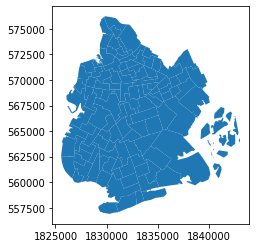

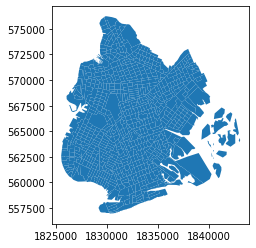

In [56]:
state = cityList.loc['NYC_Brooklyn'].state
county = cityList.loc['NYC_Brooklyn'].county
plot_friendly_1940 = gpd.read_file("nhgis0001_shape/1940_shapefiles/US_tract_1940.shp")
plot_friendly_2010 = gpd.read_file("nhgis0001_shape/2010_shapefiles/US_tract_2010.shp")

state, county
plot_friendly_1940[plot_friendly_1940.NHGISST == state][plot_friendly_1940.NHGISCTY == county].plot()
plot_friendly_2010[plot_friendly_2010.STATEFP10 == state[:-1]][plot_friendly_2010.COUNTYFP10 == county[:-1]].plot()

## Strategy for building crosswalk 

(although each 1940 tract ID has a 2010 analogue, examination of the above map shows us that there are actually multiple 2010 tracts within a 1940 tract area. So, we must average the statistics for the subset of 2010 tracts in a given 1940 tract. Doing so requires building a centroid --> point in polygon algorithm):

1. filter to just tracts from a given county
2. get centroids of 2010 tracts, add those in column to 2010 tracts df
3. for each 1940 tract, search through each 2010 tract (double for each)
4. if centroid is in polygon for the tract, add 1940 tract ID | 2010 tract ID to crosswalk dataframe

In [77]:
# helper function to get centroid of polygon
centroid = lambda x: x.centroid
def get_county_crosswalk(placeName):
    # create place_specific crosswalk dataframe
    temp_crosswalk = pd.DataFrame({'Region':[], 'Tract_1940':[], 'Tract_2010':[]})
    
    # filter to just tracts from a given county
    state = cityList.loc[placeName].state
    county = cityList.loc[placeName].county
    filtered_1940 = tracts_1940[tracts_1940.State == state][tracts_1940.County == county]
    filtered_2010 = tracts_2010[tracts_2010.State == state[:-1]][tracts_2010.County == county[:-1]]
    # get centroids of 2010 tracts, add to df
    filtered_2010['Centroid'] = filtered_2010.Geometry_2010.apply(centroid)
    
    # for each 1940 tract
    print("Current region: {}...".format(placeName))
    for index, tract in tqdm(filtered_1940.iterrows()):
        # search through each 2010 tract
        for index10, tract10 in filtered_2010.iterrows():
            # if centroid of 2010 tract is in 1940 tract geometry, add to crosswalk df
            if tract10.Centroid.within(tract.Geometry_1940):
                temp_crosswalk = temp_crosswalk.append({'Region': placeName, 
                                       'Tract_1940': tract.TractID_1940,
                                      'Tract_2010': tract10.TractID_2010}, ignore_index=True)
    
    print("Generation for {} completed!".format(placeName))
    return temp_crosswalk

# get_county_crosswalk("San Francisco")

In [78]:
cityList

,state,county
place,,
San Francisco,060,0750
Los Angeles,060,0370
NYC_Bronx,360,0050
NYC_Brooklyn,360,0470
NYC_Manhattan,360,0610
NYC_Queens,360,0810
NYC_Staten,360,0850
Chicago,170,0310
Atlanta,130,1210


In [79]:
tract_crosswalk = pd.DataFrame({'Region':[], 'Tract_1940':[], 'Tract_2010':[]})

for index, region in cityList.iterrows():
    tract_crosswalk = tract_crosswalk.append(get_county_crosswalk(index))

tract_crosswalk

/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/arunavgupta/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
4it [00:00, 31.37it/s]

Current region: San Francisco...


118it [00:03, 35.61it/s]
0it [00:00, ?it/s]

Generation for San Francisco completed!
Current region: Los Angeles...


589it [02:47,  3.52it/s]
2it [00:00, 17.56it/s]

Generation for Los Angeles completed!
Current region: NYC_Bronx...


65it [00:03, 19.82it/s]
1it [00:00,  9.65it/s]

Generation for NYC_Bronx completed!
Current region: NYC_Brooklyn...


118it [00:12,  9.82it/s]
3it [00:00, 24.58it/s]

Generation for NYC_Brooklyn completed!
Current region: NYC_Manhattan...


93it [00:03, 24.58it/s]
1it [00:00,  9.84it/s]

Generation for NYC_Manhattan completed!
Current region: NYC_Queens...


60it [00:05, 10.18it/s]
3it [00:00, 24.41it/s]

Generation for NYC_Queens completed!
Current region: NYC_Staten...


11it [00:00, 30.55it/s]
0it [00:00, ?it/s]

Generation for NYC_Staten completed!
Current region: Chicago...


935it [02:31,  6.16it/s]
4it [00:00, 38.30it/s]

Generation for Chicago completed!
Current region: Atlanta...


86it [00:02, 34.02it/s]
4it [00:00, 34.93it/s]

Generation for Atlanta completed!
Current region: Baltimore...


157it [00:04, 32.70it/s]
0it [00:00, ?it/s]

Generation for Baltimore completed!
Current region: Detroit...


451it [00:34, 13.07it/s]

Generation for Detroit completed!


,Region,Tract_1940,Tract_2010
0,San Francisco,0600750N0012,06075021400
1,San Francisco,0600750N0012,06075021300
2,San Francisco,0600750O0001,06075030500
3,San Francisco,0600750O0001,06075030102
4,San Francisco,0600750O0001,06075030101
...,...,...,...
452,Detroit,26016300664,26163504700
453,Detroit,26016300655,26163505500
454,Detroit,26016300805,26163579500
455,Detroit,26016300806,26163579800


Note that oftentimes the 2010 tract did not fall within its 1940 region!

In [80]:
tract_crosswalk.to_csv("1940-to-2010_tract_crosswalk.csv")